In [1]:
# 来看看特征工程相关的调优方法

In [2]:
# 用project3中的预测用户LTV模型来实验
import numpy as np
import pandas as pd

df_sales = pd.read_csv('易速鲜花订单记录.csv')
#数据清洗===================
# 删除重复的行
df_sales = df_sales.drop_duplicates()
# 清洗掉数量小于0的数据行
df_sales = df_sales.loc[df_sales['数量'] > 0]
#总价
df_sales['总价'] = df_sales['数量'] * df_sales['单价']
df_sales.head()

# 求出 R F M
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user


df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据


#===========================

print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))

# 求整年的 LTV 所以 把不完整的 2021年6月数据删除 时间跨度：2020 年 6 月到 2021 年 6 月 9 号
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01']
print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))

# 构建特征和标签
# 构建仅含头三个月的数据
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')]
# 索引重置
df_sales_3m.reset_index(drop=True)

df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

# 现根据数据算出每个用户据的LTV值 12个月的消费总额
# 构建每个用户整年消费总额
df_user_ly = df_sales.groupby('用户码')['总价'].sum().reset_index()
df_user_ly.columns = ['用户码', '年度LTV']
df_user_ly.head()
#构建整体LTV训练数据集
df_LTV = pd.merge(df_user_LTV, df_user_ly, on='用户码', how='left')
df_LTV


日期范围： 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00
日期范围： 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00
日期范围： 2020-06-01 09:09:00 ~ 2021-05-31 17:37:00


,用户码,R值,F值,M值,年度LTV
0,15100,49,3,876.00,876.00
1,15291,41,33,1372.19,4668.30
2,14688,6,82,1491.37,4949.83
3,15311,5,693,12859.50,59457.10
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
356,15951,1,22,375.17,375.17
357,14745,1,7,240.60,1220.26
358,15724,0,5,103.65,218.25
359,15874,0,5,584.35,4405.88


E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
E:\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()


<Axes: >

E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 29992 (\N{CJK UNIFIED IDEOGRAPH-7528}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
E:\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from f

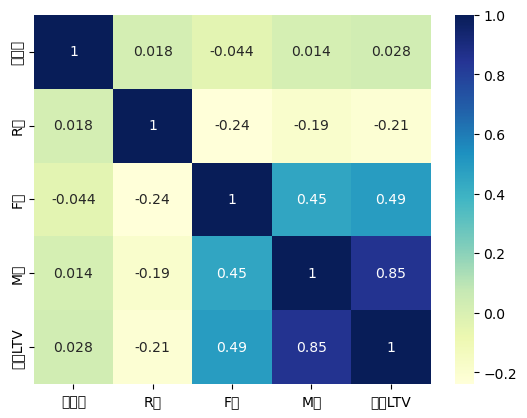

In [3]:
# 对所有的标签和特征两两显示 相关性热力图（heatmap）
import seaborn as sns
# import matplotlib.pyplot as plt
# 设置中文字体
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
# plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

sns.heatmap(df_LTV.corr(), cmap='YlGnBu', annot=True)

# 下图的方格中的数字 这类数字就是 皮尔逊相关系数，
# 表示两个变量间的线性相关性数值越接近1就代表相关性越大

In [4]:
# 构建特征集 标签集
# 数据集
# 创建特征集和标签集 特征集的X大写 标签集的y小写 （惯例）
X = df_LTV.drop(['用户码','年度LTV'], axis=1)
X.head()

y = df_LTV['年度LTV']
y.head()

from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error

model_lr = LinearRegression() 
model_lr.fit(X_train, y_train)

LinearRegression()

In [6]:
# 在这张图中 发现 M、F和LTV值相关度比较高
# 那我们丢弃R值试试
X_train_less_feature = X_train.drop(['R值'], axis=1)
X_valid_less_feature = X_valid.drop(['R值'], axis=1)
model_lr_less_feature = LinearRegression()
model_lr_less_feature.fit(X_train_less_feature, y_train)
print('测试集上的R平方分数-线性回归: %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('测试集上的R平方分数-少R值特征的线性回归: %0.4f' % r2_score(y_valid, model_lr_less_feature.predict(X_valid_less_feature)))

测试集上的R平方分数-线性回归: 0.2983
测试集上的R平方分数-少R值特征的线性回归: 0.3159


In [7]:
# 从上面的示例会发现 如果特征集中少了R值 影响确实不大 但是少了F、M值影响肯定会很大
# 但是在这个项目中并不建议将R值丢弃 因为本来特征就只有这么几个 

In [8]:
# 使用sklearn的feature_selection中的SelectKBest来自动选择特征
from sklearn.feature_selection import SelectKBest, mutual_info_regression
selector = SelectKBest(mutual_info_regression, k=2)
# 用特征选择模型拟合数据集
selector.fit(X, y)
# 输出选中的两个特征
X.columns[selector.get_support()]


Index(['F值', 'M值'], dtype='object')

In [9]:
# ------------------------------------ 特征转化---------

In [10]:
from sklearn.preprocessing import StandardScaler #导入标准化缩放器
# 使用StandardScaler 实现特征的标准缩放
scaler = StandardScaler()
# 拟合并转换训练集数据
X_train_standard = scaler.fit_transform(X_train)
# 转换验证集数据
X_valid_standard = scaler.transform(X_valid)
# 测试集也转换
X_test_standard = scaler.transform(X_test)

#可以将scaler理解为就是一个小模型，它通过训练集来拟合这个模型
# 所以第一步是fit和transform的结合
# 拟合完成之后 使用scaler就可以对验证集和测试集进行转换


In [11]:
# 使用通过标准缩放后的训练模型 得到一个rfr
from sklearn.ensemble import RandomForestRegressor
model_rfr_standard = RandomForestRegressor()
model_rfr_standard.fit(X_train_standard, y_train)

model_rfr_standard.predict(X_valid_standard)

array([  562.1326,   916.3611,   171.4972,  2365.3017,   244.815 ,
        1070.0432,  2121.6922,   413.2291,  1187.1463, 11480.7783,
        1429.1797,  1074.3902,  9539.495 ,  1930.3906,   778.2406,
         860.3233,   211.6127,  2835.6293,   994.5281,  1302.5795,
         486.1674,   994.4882,  2417.8172,   857.697 , 10700.0819,
         244.4226,  3313.2329,   715.4255,   917.1096,  1348.1296,
         847.4585,  3453.9612, 10250.0946,   787.6276,  7515.6706,
        1082.1628,  2950.8696,  1068.5229,   497.9443,  4602.3518,
        4635.98  ,  2548.4714,   529.6345,  1104.8701,  1225.9036,
         423.5847,  7779.2594,   446.4854,   409.1467,   469.2315,
        2592.826 ,   130.6335,  9201.9071, 10375.038 ])

In [12]:
# 在使用MinMaxScaler来预测用户LTV进行数值特征的归一化缩放
# 与标准的归一化相同首先要后的归一化参数
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 训练集拟合、转换
X_train_minmax = scaler.fit_transform(X_train)
# 验证集、测试集转换
X_vaild_minmax = scaler.transform(X_valid)
X_test_minmax = scaler.transform(X_test)

In [13]:
# 然后 再再再训练一个rfr
model_rfr_minmax = RandomForestRegressor()
model_rfr_minmax.fit(X_train_minmax, y_train)

RandomForestRegressor()

In [14]:
# ---------------------类别型特征的变换-----------

In [15]:
# 两个分类直接转成 0、1

In [16]:
# 多个分类使用 pandas中的get_dummies函数
# 例如将订单记录中的城市特征转成虚拟变量
category_features = ['城市']
df_sales = pd.get_dummies(df_sales, drop_first=False, columns=category_features)
df_sales

NameError: name 'dtypes' is not defined

In [ ]:
# 这样 原来的城市特征变成了 很多个特征的组合 并且值只有 True和False
# 注意drop_first参数
#    值为True的时候饭返回结果是虚拟变量
#    值为False的时候返回结果是独热编码

# 虚拟变量和独热编码的区别
# 在虚拟变量的方案中当特征具有m个不同的类别标签的时候我们将得到m-1个二进制特征，作为基准的特征会被忽略
# 在独热编码方案中我们会得到m个二进制特征

# -为什么会有这个区别
#1.如果有N个特征并且前N-1个特征值是已知的那么第N个值就能够直到了因此独热编码是由冗余的虚拟变量没有冗余的
#2.独热编码这种冗余会导致 共线性问题 也就是自变量之间存在高度相关关系，不总是相互独立的。从而使模型参数估计不准确，但是独热编码可以直接从值1看出对应的类别虚拟变量则还需要推理
# 因此独热编码更加直观 而虚拟编码需要推理 不那么直观

#  什么时候用虚拟变量 什么时候用独热编码
#    因为独热编码会导致共线性问题，那么就是针对线性模型的
#    如果线性模型有截距项，就用虚拟变量。
#    如果线性模型无截距项那就使用独热编码